_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\pdfstructure-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `van_der_pol_intermittency.dat` feeds the model with the dynamics of the Van der Pol Oscillator

In [3]:
data = np.genfromtxt('../Dataset/van_der_pol_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:] # d2x/dt2
print(gradient_tt)

1.0
1        -0.000100
2        -0.000204
3        -0.000312
4        -0.000425
5        -0.000541
            ...   
139867    0.004633
139868    0.004629
139869    0.004624
139870    0.004619
139871    0.004614
Name: 1, Length: 139871, dtype: float64
2        -0.000104
3        -0.000108
4        -0.000112
5        -0.000117
6        -0.000121
            ...   
139867   -0.000005
139868   -0.000005
139869   -0.000005
139870   -0.000005
139871   -0.000005
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_दिल्ली WIND SPEED_

In [5]:
data = pd.read_csv("../Dataset/delhi.csv")
training_set = data.iloc[:, 3]
training_set

0       0.000000
1       2.980000
2       4.633333
3       1.233333
4       3.700000
          ...   
1457    3.547826
1458    6.000000
1459    6.266667
1460    7.325000
1461    0.000000
Name: wind_speed, Length: 1462, dtype: float64

In [6]:
test = training_set.tail(10)
test
training_set = training_set.head(1452)
training_set

0        0.000000
1        2.980000
2        4.633333
3        1.233333
4        3.700000
          ...    
1447     6.420833
1448    10.414286
1449    15.926667
1450    19.404762
1451     6.180952
Name: wind_speed, Length: 1452, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True) # sets a list of integer ranging from 0 to length of training_set as index
gradient_t = gradient_t.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_t as index
gradient_tt = gradient_tt.reset_index(drop=True) # sets a list of integer ranging from 0 to length of gradient_tt as index
print(gradient_t)
print(gradient_tt)

0        -0.000100
1        -0.000204
2        -0.000312
3        -0.000425
4        -0.000541
            ...   
139866    0.004633
139867    0.004629
139868    0.004624
139869    0.004619
139870    0.004614
Name: 1, Length: 139871, dtype: float64
0        -0.000104
1        -0.000108
2        -0.000112
3        -0.000117
4        -0.000121
            ...   
139865   -0.000005
139866   -0.000005
139867   -0.000005
139868   -0.000005
139869   -0.000005
Name: 1, Length: 139870, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1) ##########[:-1]
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df, gradient_tt), axis=1) ################[:-1]
df.columns = ['y_t', 'grad_t', 'grad_tt']

In [9]:
df # DataFrame

,y_t,grad_t,grad_tt
0,0.000000,-0.000100,-0.000104
1,2.980000,-0.000204,-0.000108
2,4.633333,-0.000312,-0.000112
3,1.233333,-0.000425,-0.000117
4,3.700000,-0.000541,-0.000121
...,...,...,...
139866,NaN,0.004633,-0.000005
139867,NaN,0.004629,-0.000005
139868,NaN,0.004624,-0.000005
139869,NaN,0.004619,-0.000005


## Plot of the External Forcing from Chaotic Differential Equation (_Van der Pol Oscillator_)

<Axes: >

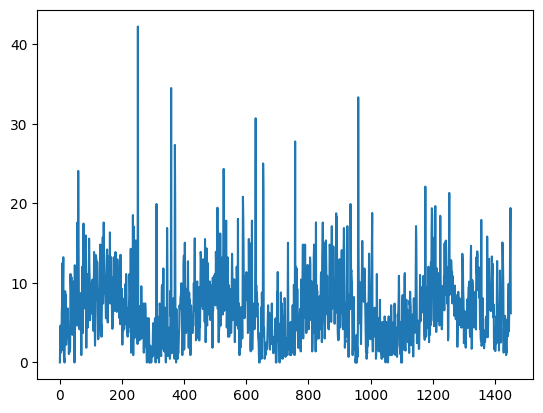

In [10]:
df.iloc[:, 0].plot()

<Axes: >

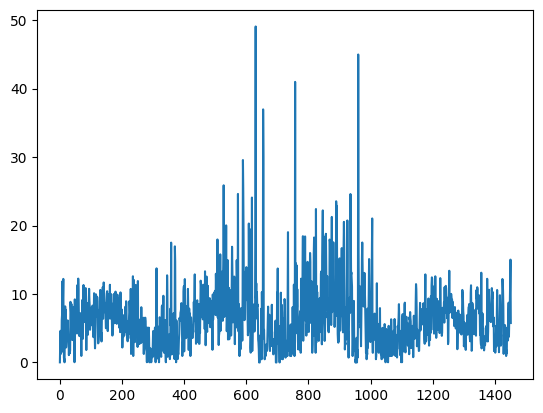

In [11]:
mu = 4
L = df.iloc[:, 2] - mu * (df.iloc[:, 1] - (df.iloc[:, 0]**2 * df.iloc[:, 1]) - (1/mu) * df.iloc[:, 0])
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 35, n_out = 10)
#data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
#       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
#       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
#       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)


data.drop(['var2(t-35)', 'var3(t-35)', 'var2(t-34)', 'var3(t-34)', 'var2(t-33)',
       'var3(t-33)', 'var2(t-32)', 'var3(t-32)', 'var2(t-31)', 'var3(t-31)',
    'var2(t-30)', 'var3(t-30)', 'var2(t-29)', 'var3(t-29)', 'var2(t-28)',
       'var3(t-28)', 'var2(t-27)', 'var3(t-27)', 'var2(t-26)', 'var3(t-26)',
       'var2(t-25)', 'var3(t-25)', 'var2(t-24)', 'var3(t-24)', 'var2(t-22)',
       'var3(t-22)', 'var2(t-21)', 'var3(t-21)','var2(t-23)', 'var3(t-23)',
       'var2(t-20)', 'var3(t-20)', 'var2(t-19)', 'var3(t-19)', 'var2(t-18)',
       'var3(t-18)', 'var2(t-17)', 'var3(t-17)', 'var2(t-16)', 'var3(t-16)',
       'var2(t-15)', 'var3(t-15)', 'var2(t-14)', 'var3(t-14)', 'var2(t-12)',
       'var3(t-12)', 'var2(t-13)', 'var3(t-13)', 'var3(t-11)', 'var2(t-11)', 'var3(t-11)',
       'var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)

print(data.head())
print(data.columns)

    var1(t-35)  var1(t-34)  var1(t-33)  var1(t-32)  var1(t-31)  var1(t-30)  \
35    0.000000    2.980000    4.633333    1.233333    3.700000    1.480000   
36    2.980000    4.633333    1.233333    3.700000    1.480000    6.300000   
37    4.633333    1.233333    3.700000    1.480000    6.300000    7.142857   
38    1.233333    3.700000    1.480000    6.300000    7.142857   12.500000   
39    3.700000    1.480000    6.300000    7.142857   12.500000    7.400000   

    var1(t-29)  var1(t-28)  var1(t-27)  var1(t-26)  ...  var3(t+6)  var1(t+7)  \
35    6.300000    7.142857   12.500000    7.400000  ...  -0.000027   7.416667   
36    7.142857   12.500000    7.400000   10.571429  ...  -0.000023   6.085714   
37   12.500000    7.400000   10.571429   13.228571  ...  -0.000020   4.333333   
38    7.400000   10.571429   13.228571    4.633333  ...  -0.000017  10.183333   
39   10.571429   13.228571    4.633333    0.616667  ...  -0.000014   8.485714   

    var2(t+7)  var3(t+7)  var1(t+8)  var2(t+

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-30:]
trainX = train[:,:-30]

In [16]:
forecasty = forecast[:,-30:]
forecastX = forecast[:,:-30]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1407, 1, 37) (1407, 30) (1, 1, 37)


In [18]:
mu = tf.Variable(4, name="mu", trainable=True, dtype=tf.float32)
splitr = 0.8

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(
        y_pred[:, 2] - mu * (y_pred[:, 1] - (y_pred[:, 0]**2 * y_pred[:, 1]) - (1/mu) * y_pred[:, 0]))
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(30))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)



Epoch 1/500

18/18 [==============================] - 7s 100ms/step - loss: 52.5155 - val_loss: 44.9846
Epoch 2/500
18/18 [==============================] - 0s 13ms/step - loss: 40.3310 - val_loss: 38.4262
Epoch 3/500
18/18 [==============================] - 0s 10ms/step - loss: 36.3514 - val_loss: 33.6525
Epoch 4/500
18/18 [==============================] - 0s 11ms/step - loss: 32.4889 - val_loss: 29.4055
Epoch 5/500
18/18 [==============================] - 0s 10ms/step - loss: 30.0293 - val_loss: 26.3014
Epoch 6/500
18/18 [==============================] - 0s 10ms/step - loss: 27.7203 - val_loss: 24.0562
Epoch 7/500
18/18 [==============================] - 0s 14ms/step - loss: 26.2569 - val_loss: 22.2174
Epoch 8/500
18/18 [==============================] - 0s 10ms/step - loss: 24.8832 - val_loss: 20.7790
Epoch 9/500
18/18 [==============================] - 0s 9ms/step - loss: 24.1720 - val_loss: 20.6007
Epoch 10/500
18/18 [==============================] - 0s 9ms/step - loss: 25.19

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 1s 1s/step


In [20]:
forecastX.shape

(1, 1, 37)

In [21]:
forecast_without_mc.shape

(1, 37)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 67)

In [24]:
fforecast = inv_yhat_without_mc[:,-30:]

In [25]:
final_forecast = fforecast[:,0:29:3]

In [26]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [27]:
# Calculate RMSE and MAE
def evaluate_forecast(actual, predicted):
    rmse = sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    return rmse, mae

# Assuming you have already forecasted values in the variable final_forecast

# Extract the actual values from the test dataset
actual_values = test.values

# Forecasted values from your model
forecast_values = final_forecast[0]  # Assuming final_forecast contains the forecasted values for the first test instance

# Calculate RMSE and MAE
rmse, mae = evaluate_forecast(actual_values, forecast_values)

# Print RMSE and MAE
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 6.145176487939564
Mean Absolute Error (MAE): 5.3108225687102255
